Estudo de classificação de processos em um dump de memória para detectar processo maliciosos

A partir de uma metodologia de análise de memória (https://repositorio.unb.br/bitstream/10482/21543/1/2016_LeandroSilvadosSantos.pdf), características de processos foram extraídas de dumps de memória onde foi executado um malware. O objetivo é identificar o processo malicioso dentro do dump de memória.

A metodologia ajudou a filtrar as informações pois dentro de um dump de memória pode existir muitos processos em execução e apenas um deles ser malicioso. Assim, a metodologia criou um ranking dos processos de forma que os processos que possuem mais atividades suspeitas receberam maior pontuação.

Dessa forma, de cada dump de memória foi utilizado apenas os 5 processos mais suspeitos de acordo com essa metodologia. O processo correspondente ao malware foi identificado por um analista que rotulou cada processo considerado no experimento.

Foram criados três datasets para realizar o estudo. O primeiro dataset considerou as seguintes características:

Caminho do processo contem appdata, ou temp? Sim/Não 

Processo Oculto: Sim/Não

Possui mutex malicioso: Sim/Não

Possui característica de backdoor: Sim/Não   

Carrega DLLs de Rede: Sim/Não

Carregou um dll com path suspeito: Sim/Não

Conecta com Ip suspeito: Sim/Não

Área de memória com permissão de escrita e execução: Sim/Não

Faz hook malicioso: Sim/Não

Possui seção de assembly suspeito: Sim/Não


Como o universo de malwares testados não possuia algumas das características do primeiro dataset, criou-se um segundo dataset removendo as caracteristicas que não determinantes e adicionou-se o campo ranking do processo que foi gerado pela metododologia. Esse campo traz a informação de quantas vezes uma atividade maliciosa foi identificada naquele processo, assim o segundo dataset possui as seguintes caracterísitcas:

Ranking

Carrega DLLs de Rede: Sim/Não

Carregou um dll com path suspeito: Sim/Não

Faz hook malicioso: Sim/Não

Possui seção de assembly suspeito: Sim/Não


O terceiro dataset adiciona a quantidade de vezes que a atividade foi identificada em determinado processo

Ranking

Quantas dll de rede

Quantas dlls com path supeito

Quantos hooks

Quantas seções de assembly suspeita



In [36]:
#Monta o google drive para acessar os datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-3.0.0-py2.py3-none-any.whl size=248525 sha256=29183fd10478184bb16316235ab96b2c71fce83737e94e2de3502a320b1a3ad8
  Stored in directory: /tmp/pip-ephem-wheel-cache-5cktym_r/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


In [38]:
#Importa as bibliotecas
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from pandas_profiling import ProfileReport




In [39]:
#Carrega o primeiro data set em um dataframe
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

df

APPDATA_TEMP_FOLDER   HIDDEN_PROCESS   ...  DLL_APPDATA_TEMP_PATH  Malware
0                       1                0  ...                      1        0
1                       0                0  ...                      0        1
2                       0                0  ...                      0        0
3                       0                0  ...                      0        0
4                       0                0  ...                      1        0
..                    ...              ...  ...                    ...      ...
122                     1                0  ...                      1        1
123                     0                0  ...                      1        0
124                     0                0  ...                      0        0
125                     0                0  ...                      0        0
126                     0                0  ...                      1        0

[127 rows x 11 columns]

In [40]:
df.columns


Index(['APPDATA_TEMP_FOLDER ', 'HIDDEN_PROCESS ', 'MALICIOUS_MUTEX ',
       'BACKDOOR ', 'NETWORK_DLL ', 'SUSPICIOUS_PORT_CONNECTION ',
       'WRITE_MEMORY ', 'HOOK ', 'SUSPICIOUS_SECTION ',
       'DLL_APPDATA_TEMP_PATH', 'Malware'],
      dtype='object')

In [41]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
X = df[['APPDATA_TEMP_FOLDER ','HIDDEN_PROCESS ', 'MALICIOUS_MUTEX ',
       'BACKDOOR ', 'NETWORK_DLL ', 'SUSPICIOUS_PORT_CONNECTION ',
       'WRITE_MEMORY ', 'HOOK ', 'SUSPICIOUS_SECTION ',
       'DLL_APPDATA_TEMP_PATH']]
X

APPDATA_TEMP_FOLDER   ...  DLL_APPDATA_TEMP_PATH
0                       1  ...                      1
1                       0  ...                      0
2                       0  ...                      0
3                       0  ...                      0
4                       0  ...                      1
..                    ...  ...                    ...
122                     1  ...                      1
123                     0  ...                      1
124                     0  ...                      0
125                     0  ...                      0
126                     0  ...                      1

[127 rows x 10 columns]

In [43]:
y = df [['Malware']]
y

Malware
0          0
1          1
2          0
3          0
4          0
..       ...
122        1
123        0
124        0
125        0
126        0

[127 rows x 1 columns]

In [44]:
#Seprando os dados de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [45]:
#Testando o primeiro classificador - KNN
KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train.values.ravel()).score(X_test,y_test.values.ravel())

0.7692307692307693

In [46]:
# test_size=0.40
# n_neighbors=9
# random_state=5575

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=5575, stratify=y)
knn = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train.values.ravel())
knn.score(X_test,y_test.values.ravel())


0.9411764705882353

In [47]:
from sklearn import metrics

In [48]:
metrics.f1_score(y_test, knn.predict(X_test), average='weighted')

0.9380641145347027

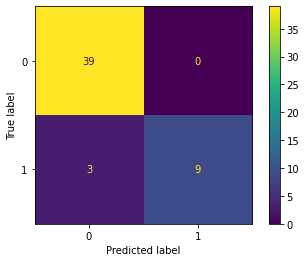

In [49]:
y_pred = knn.predict(X_test) 
plot_confusion_matrix(knn, X_test, y_test)


In [50]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       0.93      1.00      0.96        39
     Malware       1.00      0.75      0.86        12

    accuracy                           0.94        51
   macro avg       0.96      0.88      0.91        51
weighted avg       0.95      0.94      0.94        51



**Após** definir os parâmentros test_size, random_state e n_neighbors certos, conseguimos 94%.

<!-- 
# test_size=0.51
# n_neighbors=6
# random_state=5474 
-->

<!-- Na digonal principal da matrix de confusão podemos identificar as previsões que o modelo acertou. Ou seja, ele acertou que 48 processo não são malewares e 4 processos são malwares. -->

<!-- Além disso, E correu 11 falsos negativos, pois o modelo não identificou dois processo que são maliciosos e 2 falsos positivos. -->

In [51]:
# melhor = []
# for s in range(1, 999):
#  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=s, stratify=y)
#  for n in range(1, 20):
#    melhor.append([KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train.values.ravel()).score(X_test,y_test.values.ravel()), n, s])
# omelhor = max(melhor)
# print(omelhor)

# for j in range(1, 10):
#  melhor = []
#  for s in range(1000*j, 1000*j+999):
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=s, stratify=y)
#    for n in range(1, 20):
#      melhor.append([KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train.values.ravel()).score(X_test,y_test.values.ravel()), n, s])
#  omelhor = max(melhor)
#  print(omelhor)

# [1.0, 3, 510]
# [1.0, 3, 1255]
# [1.0, 3, 2281]
# [1.0, 3, 3548]
# [1.0, 3, 4840]
# [1.0, 3, 5124]
# [1.0, 3, 6974]
# [1.0, 3, 7710]
# [1.0, 3, 8400]
# [1.0, 1, 9470]

In [52]:
y_train

Malware
72         0
10         0
30         0
123        0
111        0
..       ...
44         0
93         0
8          0
12         0
45         1

[76 rows x 1 columns]

In [53]:
#Testando o segundo modelo de classificação - Regressão Logística

reg_log = linear_model.LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='auto',class_weight='balanced')
reg_log.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
reg_log.score(X_test, y_test)

0.8431372549019608

In [55]:
metrics.f1_score(y_test, reg_log.predict(X_test), average='weighted')

0.8522875816993465

Teve um taxa de acerto menor que o knn

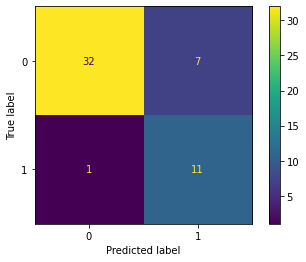

In [56]:
y_pred = reg_log.predict(X_test)
plot_confusion_matrix(reg_log, X_test, y_test)

In [57]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       0.97      0.82      0.89        39
     Malware       0.61      0.92      0.73        12

    accuracy                           0.84        51
   macro avg       0.79      0.87      0.81        51
weighted avg       0.89      0.84      0.85        51



Novamente na digonal principal são as previsões que o modelo acertou. Tivemos 3 falsos positivos, processos que o modelo classificou como malware mas não são e 10 falsos negativos, processos que são malwares e não foram classificados corretamente.

In [58]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=10, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.769871794871795


0.15132686211607022

In [59]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=3, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.7478774455518642


0.02386026225351393

In [60]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=5, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.7781538461538462


0.07655542912041345

In [61]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [62]:
tree = DecisionTreeClassifier(min_samples_leaf=5).fit(X_train, y_train)
print(tree.score(X_test, y_test))
metrics.f1_score(y_test, tree.predict(X_test), average='weighted')

0.7843137254901961


0.7487889273356402

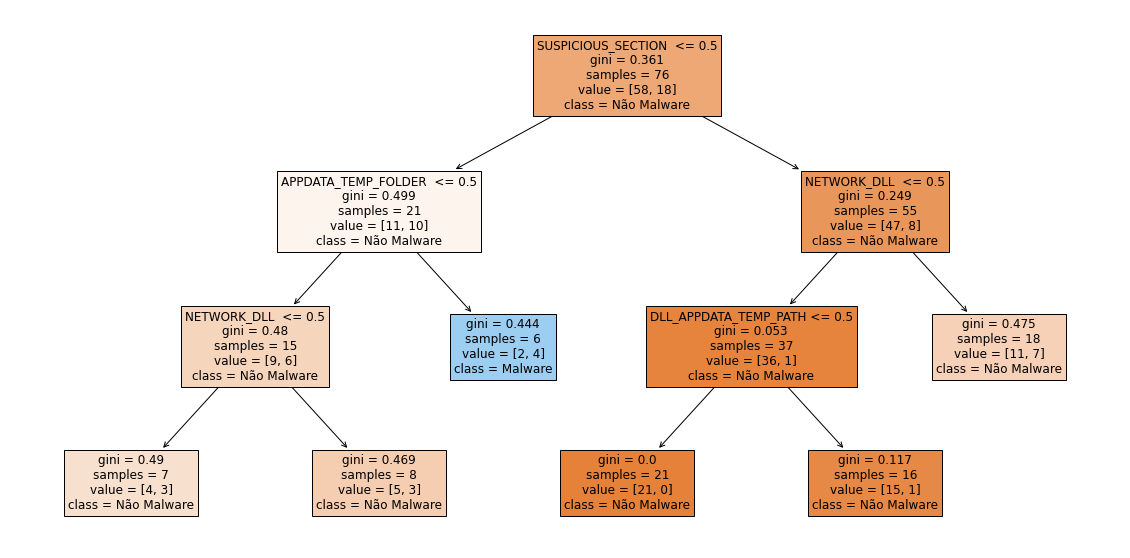

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plot_tree(tree,filled=True, fontsize=12, feature_names=X.columns, 
          class_names=target_names)
plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf=5).fit(X_train, y_train.values.ravel())
print(rf.score(X_test, y_test.values.ravel()))
y_pred = rf.predict(X_test)
metrics.f1_score(y_test, y_pred, average='weighted')

0.7647058823529411


0.6627450980392157

In [65]:
from sklearn import svm
svm_clf = svm.SVC(C=1.0).fit((X_train), y_train.values.ravel())
print(svm_clf.score((X_test), y_test.values.ravel()))
metrics.f1_score(y_test, svm_clf.predict((X_test)), average='weighted')

0.8235294117647058


0.7797160243407708

In [66]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier



eclf = VotingClassifier(
    estimators=[('log_reg', reg_log), ('tree', tree),('RF', rf), ('svm', svm_clf)],
    voting='hard')



for clf, label in zip([reg_log,  tree, rf, svm_clf, eclf], ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train.values.ravel(), scoring='accuracy', cv=4)
    print(f"{label} : {scores.mean():0.3f} (+/- {scores.std():0.3f})")
    

Logistic Regression : 0.671 (+/- 0.044)
Decision Tree : 0.737 (+/- 0.037)
Random Forest : 0.763 (+/- 0.026)
SVM : 0.763 (+/- 0.026)
Ensemble : 0.763 (+/- 0.026)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


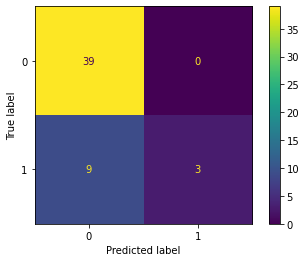

In [67]:
ensemble = eclf.fit(X_train,y_train)
y_pred = ensemble.predict(X_test)
plot_confusion_matrix(ensemble, X_test, y_test)

Após testar a validação cruzada com 3, 10, 5 percebemos que a média de acerto não varia de maneira significativa.




In [68]:
#Carregando o segundo dataset
df = pd.read_csv('/content/drive/MyDrive/dataset_v2.csv')

df

pid         process  rankig  ...  dll_path  dll_rede  Malware
0    7484    OneDrive.exe   55907  ...         1         1        0
1    4812    acroedit.exe   17086  ...         1         1        1
2    6640       putty.exe   11199  ...         1         1        1
3    4340    explorer.exe     262  ...         1         0        0
4    4056   taskhostw.exe     204  ...         0         1        0
..    ...             ...     ...  ...       ...       ...      ...
137  6860    OneDrive.exe   45412  ...         1         1        0
138  7912       putty.exe    4074  ...         0         1        1
139  4248    explorer.exe     262  ...         1         0        0
140  2708  SecurityHealth     155  ...         0         1        0
141  6772    MSASCuiL.exe     130  ...         0         0        0

[142 rows x 9 columns]

In [69]:
df.columns

Index(['pid', 'process', 'rankig', 'hook', 'path_appdata_temp',
       'assembly_section', 'dll_path', 'dll_rede', 'Malware'],
      dtype='object')

In [70]:
#Carregando apenas as caracteríticas que serão usadas para as previsões
X = df[['rankig', 'hook', 'path_appdata_temp',
       'assembly_section', 'dll_path', 'dll_rede']]
X


rankig  hook  path_appdata_temp  assembly_section  dll_path  dll_rede
0     55907     1                  1                 1         1         1
1     17086     1                  1                 0         1         1
2     11199     1                  1                 1         1         1
3       262     1                  1                 1         1         0
4       204     1                  0                 0         0         1
..      ...   ...                ...               ...       ...       ...
137   45412     1                  1                 1         1         1
138    4074     1                  0                 1         0         1
139     262     1                  1                 1         1         0
140     155     1                  0                 0         0         1
141     130     1                  0                 0         0         0

[142 rows x 6 columns]

In [71]:
profile = ProfileReport(df[['rankig', 'hook', 'path_appdata_temp',
       'assembly_section', 'dll_path', 'dll_rede', 'Malware']], title="Pandas Profiling Report")

profile

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [72]:
y = df [['Malware']]
y

Malware
0          0
1          1
2          1
3          0
4          0
..       ...
137        0
138        1
139        0
140        0
141        0

[142 rows x 1 columns]

In [73]:
#Seprando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [74]:
#Treinando o knn no segundo dataset
knn = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train.values.ravel())
knn.score(X_test,y_test.values.ravel())

0.9767441860465116

In [75]:
metrics.f1_score(y_test, knn.predict(X_test), average='weighted')

0.9763057417928717

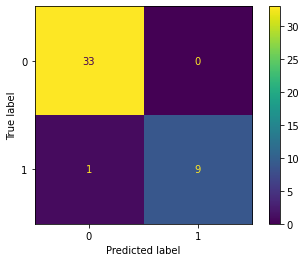

In [76]:
y_pred = knn.predict(X_test) 
plot_confusion_matrix(knn, X_test, y_test)

In [77]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       0.97      1.00      0.99        33
     Malware       1.00      0.90      0.95        10

    accuracy                           0.98        43
   macro avg       0.99      0.95      0.97        43
weighted avg       0.98      0.98      0.98        43



Tivemos 4 falsos negativios nesse modelo. Considero ser o erro mais grave pois o falto negativo é menos prejudicial ao negócio.

In [78]:
reg_log = linear_model.LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='auto',class_weight='balanced')
reg_log.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
reg_log.score(X_test, y_test)

0.7674418604651163

In [80]:
metrics.f1_score(y_test, reg_log.predict(X_test), average='weighted')

0.6664626682986536

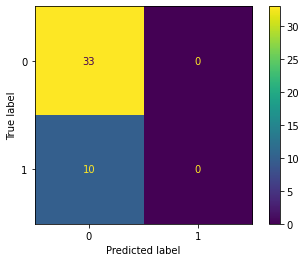

In [81]:
y_pred = reg_log.predict(X_test)
plot_confusion_matrix(reg_log, X_test, y_test)

In [82]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       0.77      1.00      0.87        33
     Malware       0.00      0.00      0.00        10

    accuracy                           0.77        43
   macro avg       0.38      0.50      0.43        43
weighted avg       0.59      0.77      0.67        43



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Através dessa matrix de confusão, vemos que este modelo preferiu chutar que todos os processo não são malware, pois realmente a maioria dos processos não serão maliciosos. Isso mostra como nosso dataset está desbalanceado.

In [83]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=10, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.6966666666666667


0.10722325026236333

In [84]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=3, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.7606382978723404


0.007522412565814333

In [85]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=5, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.7605911330049261


0.01313988046142772

In [86]:
tree = DecisionTreeClassifier(min_samples_leaf=5).fit(X_train, y_train)
print(tree.score(X_test, y_test))
metrics.f1_score(y_test, tree.predict(X_test), average='weighted')

0.9534883720930233


0.9534883720930233

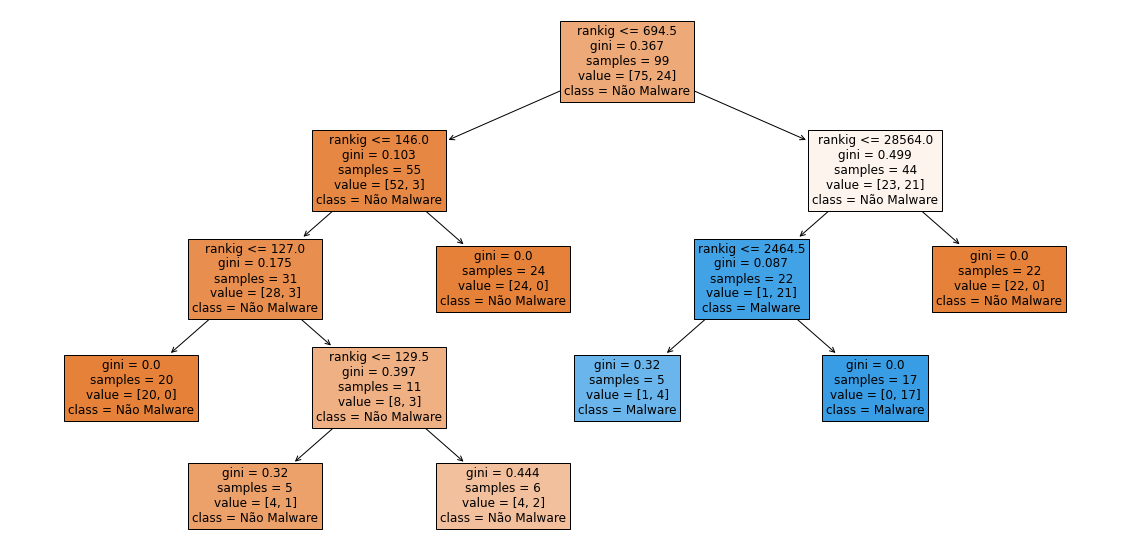

In [87]:
plt.figure(figsize=(20,10))
plot_tree(tree,filled=True, fontsize=12, feature_names=X.columns, 
          class_names=target_names)
plt.show()

In [88]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf=5).fit(X_train, y_train.values.ravel())
print(rf.score(X_test, y_test.values.ravel()))
y_pred = rf.predict(X_test)
metrics.f1_score(y_test, y_pred, average='weighted')

0.8604651162790697


0.8470099667774086

In [89]:
from sklearn import svm
svm_clf = svm.SVC(C=1.0).fit((X_train), y_train.values.ravel())
print(svm_clf.score((X_test), y_test.values.ravel()))
metrics.f1_score(y_test, svm_clf.predict((X_test)), average='weighted')

0.9302325581395349


0.9255932909058465

In [90]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier



eclf = VotingClassifier(
    estimators=[('log_reg', reg_log), ('tree', tree),('RF', rf), ('svm', svm_clf)],
    voting='hard')

for clf, label in zip([reg_log,  tree, rf, svm_clf, eclf], ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train.values.ravel(), scoring='accuracy', cv=4)
    print(f"{label} : {scores.mean():0.3f} (+/- {scores.std():0.3f})")

Logistic Regression : 0.758 (+/- 0.004)
Decision Tree : 0.939 (+/- 0.021)
Random Forest : 0.888 (+/- 0.062)
SVM : 0.858 (+/- 0.046)
Ensemble : 0.828 (+/- 0.060)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


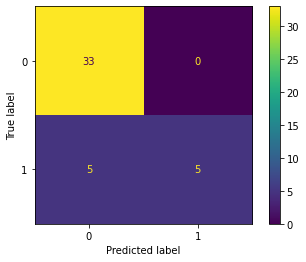

In [91]:
ensemble = eclf.fit(X_train,y_train)
y_pred = ensemble.predict(X_test)
plot_confusion_matrix(ensemble, X_test, y_test)

Após testar a validação cruzada com 3, 10, 5 percebemos que a média de acerto não varia de maneira significativa.

In [92]:
df = pd.read_csv('/content/drive/MyDrive/dataset_v3.csv')

df

pid  ...                               Unnamed: 14
0    7484  ...  ff69d0aff85855980d01fe2fdf64e62e9ed7c944
1    4812  ...                                       NaN
2    6640  ...                                       NaN
3    4340  ...                                       NaN
4    4056  ...                                       NaN
..    ...  ...                                       ...
152  3616  ...  ecdda7aca5c805e5be6e0ab2017592439de7e32c
153  4480  ...                                       NaN
154  1324  ...                                       NaN
155  3760  ...                                       NaN
156  4992  ...                                       NaN

[157 rows x 15 columns]

In [93]:
df.columns


Index(['pid', 'process', 'rankig', 'hook', 'path_appdata_temp',
       'assembly_section', 'dll_path', 'dll_rede', 'Malware', 'qt_dll_rede',
       'qt_hook', 'qt_assembly', 'qt_dll_path', 'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')

In [94]:
X = df[['rankig', 'qt_dll_rede', 'qt_hook', 'qt_assembly', 'qt_dll_path']]
X

rankig  qt_dll_rede  qt_hook  qt_assembly  qt_dll_path
0     55907            4    11054            1          122
1     17086            4     3407            0            6
2     11199            4     2232            1            4
3       262            0       47            1            4
4       204            2       40            0            0
..      ...          ...      ...          ...          ...
152   52917            4    10456            1          122
153     262            0       47            1            4
154     159            0       30            1            0
155     121            4       22            1            0
156      94            2       18            0            0

[157 rows x 5 columns]

In [95]:
profile = ProfileReport(df[['rankig', 'qt_dll_rede', 'qt_hook', 'qt_assembly', 'qt_dll_path', 'Malware']], title="Pandas Profiling Report")

profile


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [96]:
from sklearn.preprocessing import MinMaxScaler

In [97]:
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(X)
scaled

array([[7.06645241e-01, 1.00000000e+00, 7.04178628e-01, 1.00000000e+00,
        9.68253968e-01],
       [2.15451578e-01, 1.00000000e+00, 2.16331738e-01, 0.00000000e+00,
        4.76190476e-02],
       [1.40964648e-01, 1.00000000e+00, 1.41371611e-01, 1.00000000e+00,
        3.17460317e-02],
       [2.58116760e-03, 0.00000000e+00, 1.97767145e-03, 1.00000000e+00,
        3.17460317e-02],
       [1.84730622e-03, 5.00000000e-01, 1.53110048e-03, 0.00000000e+00,
        0.00000000e+00],
       [7.62001164e-01, 1.00000000e+00, 7.59744817e-01, 1.00000000e+00,
        1.00000000e+00],
       [4.94470734e-02, 5.00000000e-01, 4.95055821e-02, 1.00000000e+00,
        0.00000000e+00],
       [5.20029354e-03, 0.00000000e+00, 4.91228070e-03, 1.00000000e+00,
        0.00000000e+00],
       [2.58116760e-03, 0.00000000e+00, 1.97767145e-03, 1.00000000e+00,
        3.17460317e-02],
       [8.47736417e-04, 0.00000000e+00, 5.10366826e-04, 0.00000000e+00,
        0.00000000e+00],
       [2.64443151e-03, 0.0000

In [98]:
X.columns

Index(['rankig', 'qt_dll_rede', 'qt_hook', 'qt_assembly', 'qt_dll_path'], dtype='object')

In [99]:
feature_names = X.columns
X=scaled

In [100]:
y = df[['Malware']]
y

Malware
0          0
1          1
2          1
3          0
4          0
..       ...
152        0
153        0
154        0
155        0
156        0

[157 rows x 1 columns]

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [102]:
KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train.values.ravel()).score(X_test,y_test.values.ravel())

0.7916666666666666

In [103]:
knn = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train.values.ravel())
knn.score(X_test,y_test.values.ravel())

0.8541666666666666

In [104]:
metrics.f1_score(y_test, knn.predict(X_test), average='weighted')

0.83060312732688

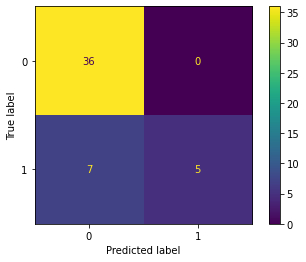

In [105]:
y_pred = knn.predict(X_test) 
plot_confusion_matrix(knn, X_test, y_test)

In [106]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       0.84      1.00      0.91        36
     Malware       1.00      0.42      0.59        12

    accuracy                           0.85        48
   macro avg       0.92      0.71      0.75        48
weighted avg       0.88      0.85      0.83        48



In [107]:
reg_log = linear_model.LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='auto',class_weight='balanced')
reg_log.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
reg_log.score(X_test, y_test)


0.6666666666666666

In [109]:
metrics.f1_score(y_test, reg_log.predict(X_test), average='weighted')

0.6857142857142856

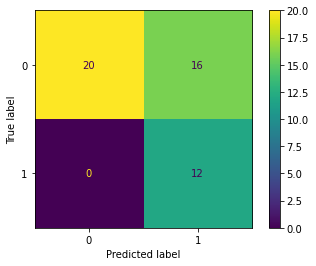

In [110]:
y_pred = reg_log.predict(X_test)
plot_confusion_matrix(reg_log, X_test, y_test)

In [111]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       1.00      0.56      0.71        36
     Malware       0.43      1.00      0.60        12

    accuracy                           0.67        48
   macro avg       0.71      0.78      0.66        48
weighted avg       0.86      0.67      0.69        48



In [112]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=10, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.6745833333333333


0.05600874187719866

In [113]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=3, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.6877116594097726


0.02069664260367007

In [114]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=5, scoring='accuracy', )

print(cv_result.mean())
cv_result.std()

0.6683467741935483


0.04639725762465331

In [115]:
tree = DecisionTreeClassifier(min_samples_leaf=5).fit(X_train, y_train)
print(tree.score(X_test, y_test))
metrics.f1_score(y_test, tree.predict(X_test), average='weighted')

0.9791666666666666


0.978856462179869

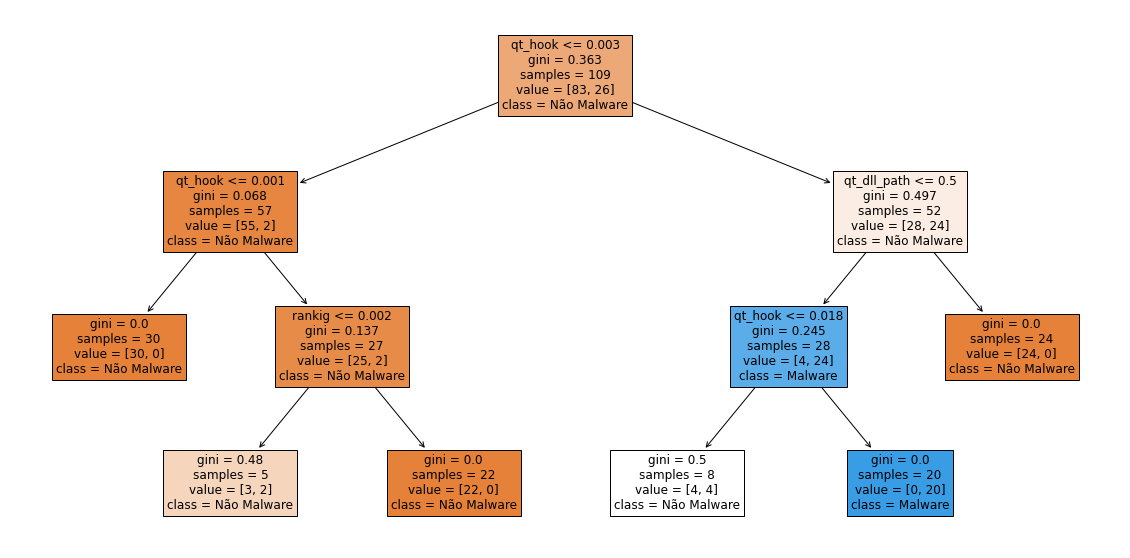

In [116]:
plt.figure(figsize=(20,10))
plot_tree(tree,filled=True, fontsize=12, feature_names=feature_names, 
          class_names=target_names)
plt.show()

In [117]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf=5).fit(X_train, y_train.values.ravel())
print(rf.score(X_test, y_test.values.ravel()))
y_pred = rf.predict(X_test)
metrics.f1_score(y_test, y_pred, average='weighted')

0.9791666666666666


0.9794366197183099

In [118]:
from sklearn import svm
svm_clf = svm.SVC(C=1.0).fit((X_train), y_train.values.ravel())
print(svm_clf.score((X_test), y_test.values.ravel()))
metrics.f1_score(y_test, svm_clf.predict((X_test)), average='weighted')

0.8333333333333334


0.7999999999999999

In [119]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier



eclf = VotingClassifier(
    estimators=[('log_reg', reg_log), ('tree', tree),('RF', rf), ('svm', svm_clf)],
    voting='hard')

for clf, label in zip([reg_log,  tree, rf, svm_clf, eclf], ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train.values.ravel(), scoring='accuracy', cv=4)
    print(f"{label} : {scores.mean():0.3f} (+/- {scores.std():0.3f})")

Logistic Regression : 0.614 (+/- 0.132)
Decision Tree : 0.899 (+/- 0.017)
Random Forest : 0.908 (+/- 0.019)
SVM : 0.762 (+/- 0.017)
Ensemble : 0.898 (+/- 0.041)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


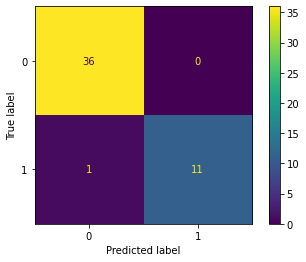

In [120]:
ensemble = eclf.fit(X_train,y_train)
y_pred = ensemble.predict(X_test)
plot_confusion_matrix(ensemble, X_test, y_test)

Dividir em 5 possui media melhor com desvio padrão ligeiramente melhor

Vamos testar retirando o ranking processado pelo maldetect

In [121]:
X = df[['qt_dll_rede', 'qt_hook', 'qt_assembly', 'qt_dll_path']]
X

qt_dll_rede  qt_hook  qt_assembly  qt_dll_path
0              4    11054            1          122
1              4     3407            0            6
2              4     2232            1            4
3              0       47            1            4
4              2       40            0            0
..           ...      ...          ...          ...
152            4    10456            1          122
153            0       47            1            4
154            0       30            1            0
155            4       22            1            0
156            2       18            0            0

[157 rows x 4 columns]

In [122]:
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(X)
scaled

array([[1.00000000e+00, 7.04178628e-01, 1.00000000e+00, 9.68253968e-01],
       [1.00000000e+00, 2.16331738e-01, 0.00000000e+00, 4.76190476e-02],
       [1.00000000e+00, 1.41371611e-01, 1.00000000e+00, 3.17460317e-02],
       [0.00000000e+00, 1.97767145e-03, 1.00000000e+00, 3.17460317e-02],
       [5.00000000e-01, 1.53110048e-03, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 7.59744817e-01, 1.00000000e+00, 1.00000000e+00],
       [5.00000000e-01, 4.95055821e-02, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.91228070e-03, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.97767145e-03, 1.00000000e+00, 3.17460317e-02],
       [0.00000000e+00, 5.10366826e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.97767145e-03, 1.00000000e+00, 3.17460317e-02],
       [5.00000000e-01, 7.65550239e-04, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.01754386e-04, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.82775120e-04, 1.00000000e

In [123]:
feature_names = X.columns
X=scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [124]:
KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train.values.ravel()).score(X_test,y_test.values.ravel())

0.7916666666666666

In [125]:
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train.values.ravel())
knn.score(X_test,y_test.values.ravel())

0.7916666666666666

In [126]:
metrics.f1_score(y_test, knn.predict(X_test), average='weighted')

0.7299651567944251

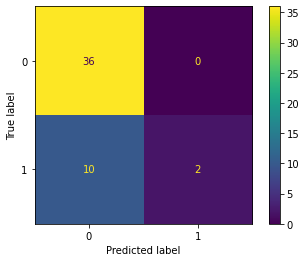

In [127]:
y_pred = knn.predict(X_test) 
plot_confusion_matrix(knn, X_test, y_test)

In [128]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       0.78      1.00      0.88        36
     Malware       1.00      0.17      0.29        12

    accuracy                           0.79        48
   macro avg       0.89      0.58      0.58        48
weighted avg       0.84      0.79      0.73        48



In [129]:
reg_log = linear_model.LogisticRegression(max_iter=5000, solver='lbfgs', multi_class='auto',class_weight='balanced')
reg_log.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [130]:
reg_log.score(X_test, y_test)

0.6666666666666666

In [131]:
metrics.f1_score(y_test, reg_log.predict(X_test), average='weighted')

0.6857142857142856

In [132]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=10, scoring='accuracy', )

print(cv_result)
print(cv_result.mean())
cv_result.std()

[0.625      0.75       0.75       0.6875     0.625      0.6875
 0.6875     0.73333333 0.6        0.6       ]
0.6745833333333333


0.05600874187719866

In [133]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=3, scoring='accuracy', )

print(cv_result)
print(cv_result.mean())
cv_result.std()

[0.71698113 0.67307692 0.67307692]
0.6877116594097726


0.02069664260367007

In [134]:
cv_result = cross_val_score(reg_log, X, y.values.ravel(), cv=5, scoring='accuracy', )

print(cv_result)
print(cv_result.mean())
cv_result.std()

[0.6875     0.71875    0.61290323 0.70967742 0.61290323]
0.6683467741935483


0.04639725762465331

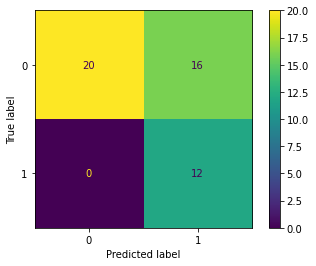

In [135]:
y_pred = reg_log.predict(X_test) 
plot_confusion_matrix(reg_log, X_test, y_test)

In [136]:
target_names = ['Não Malware', 'Malware']
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Não Malware       1.00      0.56      0.71        36
     Malware       0.43      1.00      0.60        12

    accuracy                           0.67        48
   macro avg       0.71      0.78      0.66        48
weighted avg       0.86      0.67      0.69        48



In [137]:
tree = DecisionTreeClassifier(min_samples_leaf=5).fit(X_train, y_train)
print(tree.score(X_test, y_test))
metrics.f1_score(y_test, tree.predict(X_test), average='weighted')

0.9791666666666666


0.978856462179869

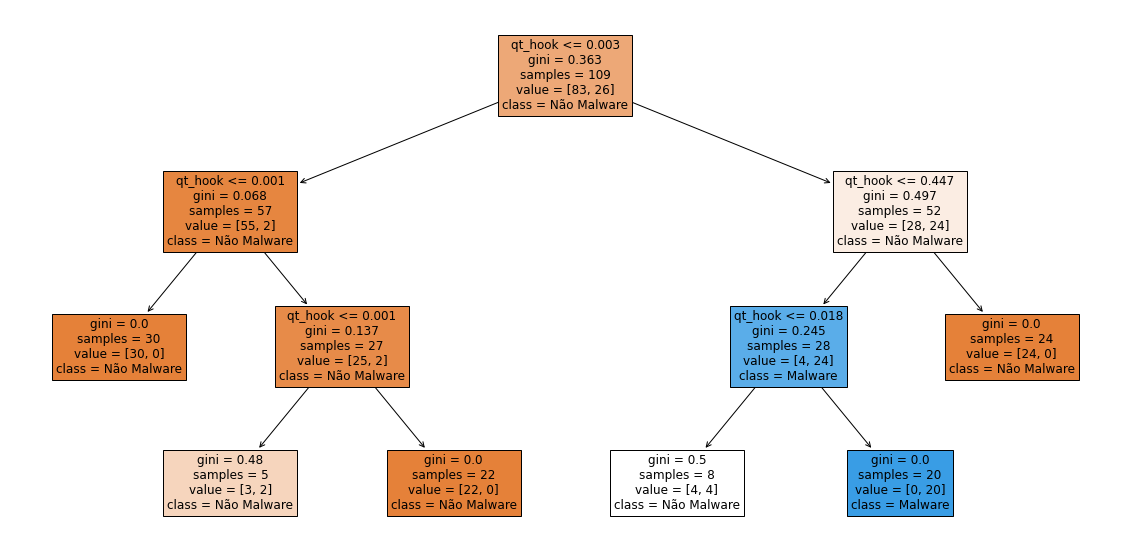

In [138]:
plt.figure(figsize=(20,10))
plot_tree(tree,filled=True, fontsize=12, feature_names=feature_names, 
          class_names=target_names)
plt.show()

In [139]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_leaf=5).fit(X_train, y_train.values.ravel())
print(rf.score(X_test, y_test.values.ravel()))
y_pred = rf.predict(X_test)
metrics.f1_score(y_test, y_pred, average='weighted')

0.9791666666666666


0.9794366197183099

In [140]:
from sklearn import svm
svm_clf = svm.SVC(C=1.0).fit((X_train), y_train.values.ravel())
print(svm_clf.score((X_test), y_test.values.ravel()))
metrics.f1_score(y_test, svm_clf.predict((X_test)), average='weighted')

0.8541666666666666


0.83060312732688

In [141]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier



eclf = VotingClassifier(
    estimators=[('log_reg', reg_log), ('tree', tree),('RF', rf), ('svm', svm_clf)],
    voting='hard')

for clf, label in zip([reg_log,  tree, rf, svm_clf, eclf], ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'Ensemble']):
    scores = cross_val_score(clf, X_train, y_train.values.ravel(), scoring='accuracy', cv=4)
    print(f"{label} : {scores.mean():0.3f} (+/- {scores.std():0.3f})")

Logistic Regression : 0.614 (+/- 0.132)
Decision Tree : 0.899 (+/- 0.017)
Random Forest : 0.908 (+/- 0.019)
SVM : 0.762 (+/- 0.017)
Ensemble : 0.908 (+/- 0.033)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


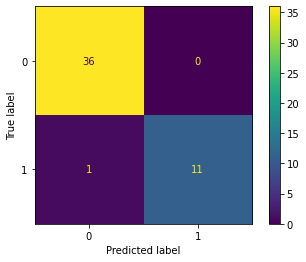

In [142]:
ensemble = eclf.fit(X_train,y_train)
y_pred = ensemble.predict(X_test)
plot_confusion_matrix(ensemble, X_test, y_test)

In [143]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

     |████████████████████████████████| 61kB 4.5MB/s 


In [144]:
import sys
import os
# add library module to PYTHONPATH
sys.path.append(f"{os.getcwd()}/../")

In [145]:
pd.__version__

'1.1.5'

## lembrar
treinar svm, trocar gausiana no ensemble, trocar a acuracia pela f1 score, corrigir os comentarios



Podemos concluir que o valor do ranking, e a quantidade de vezes que cada atividade foi detectada ajuda o modelo a fazer previsões melhores